Tabs you need to have open: [this one](https://www.kaggle.com/phunghieu/connectx-with-deep-q-learning#Define-useful-classes) and [this one](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

# Install kaggle-environments

In [1]:
# !pip install 'kaggle-environments>=0.1.6'

In [54]:
from tqdm.notebook import tqdm
import gym
import sys
sys.path.append('../src/')


In [76]:

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


from dqn import DQN
from env import ConnectX
from replay_memory import ReplayMemory
from helpers import preprocess, select_action, optimize_model


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1200
TARGET_UPDATE = 100
HIDDEN_UNITS = 100

env = ConnectX()
policy_net = DQN(env.observation_space.n+1, HIDDEN_UNITS, env.action_space.n).to(device)
target_net = DQN(env.observation_space.n+1, HIDDEN_UNITS, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)





num_episodes = 5000
pbar = tqdm(range(num_episodes))
all_total_rewards = np.empty(num_episodes)
all_avg_rewards = np.empty(num_episodes) # Last 100 steps
all_epsilons = np.empty(num_episodes)


for i_episode in pbar:
    

    state = env.reset()
    state = preprocess(state)
    rewards = 0
    for t in count():
        
        # Select and perform an action
        eps = EPS_END + (EPS_START - EPS_END) * \
                math.exp(-1. * i_episode / EPS_DECAY)

        action = select_action(state, eps, policy_net, env)
        next_state, reward, done, _ = env.step(action.item())
        next_state = preprocess(next_state)
        # Observe new state
        if not done:
            reward = -0.05 # Try to prevent the agent from taking a long move
        else:
            next_state = None
            # Apply new rules
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else:  # Draw
                reward = 10
             
        reward = torch.tensor([reward], device=device).float()
        rewards += reward
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one optimization step on the target network
        optimize_model(optimizer=optimizer, batch_size=BATCH_SIZE, memory=memory, policy_net=policy_net, target_net=target_net, gamma=GAMMA)
        
        if done:
            break
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    all_total_rewards[i_episode] = rewards
    avg_reward = all_total_rewards[max(0, i_episode - 100):(i_episode + 1)].mean()
    all_avg_rewards[i_episode] = avg_reward
    all_epsilons[i_episode] = eps
            
    pbar.set_postfix({
        'episode reward': rewards,
        'avg (100 last) reward': avg_reward,
        'epsilon': eps
    })

In [75]:
env.pair

[None, 'random']

In [74]:
env.render()

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 2 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 2 | 1 | 0 |
+---+---+---+---+---+---+---+
| 1 | 2 | 0 | 2 | 1 | 1 | 0 |
+---+---+---+---+---+---+---+
| 1 | 2 | 2 | 1 | 2 | 1 | 0 |
+---+---+---+---+---+---+---+



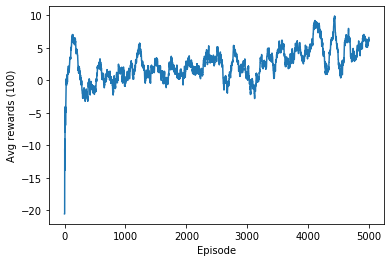

In [77]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()


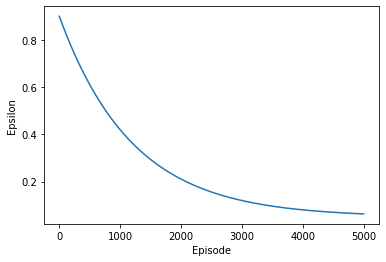

In [78]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()


In [68]:
# This agent random chooses a non-empty column.
def my_agent(observation, action_space, policy_net=policy_net):
    state = preprocess(observation)
    with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)

# Test your Agent

In [70]:
env.reset()
# Play as the first agent against default "random" agent.
env.env.run([my_agent, "random"])
env.render(mode="ipython", width=500, height=450)

# Debug/Train your Agent

In [47]:
# Play as first position against random agent.
# trainer = env.train([None, "random"])

observation = env.reset()

while True:
    my_action = my_agent(observation, env.action_space.n)
#     print(observation)
    
#     print("My Action", my_action)
    observation, reward, done, info = env.step(my_action)
    if done:
        break
#     env.render(mode="ipython", width=100, height=90, header=False, controls=False)
env.render()

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 1 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 2 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 0 | 2 |
+---+---+---+---+---+---+---+
| 1 | 1 | 0 | 0 | 0 | 2 | 1 |
+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 2 | 2 | 2 | 1 |
+---+---+---+---+---+---+---+
| 2 | 2 | 1 | 1 | 2 | 2 | 1 |
+---+---+---+---+---+---+---+



# Evaluate your Agent

In [ ]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

# Play your Agent
Click on any column to place a checker there ("manually select action").

In [ ]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([my_agent, None], width=500, height=450)

# Write Submission File



In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "../submissions/submission.py")

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("../submissions/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.